# Analysing Face Detection on African data

### Importing Libraries

In [1]:
import gc
import os
import sys
import math
import glob
import tqdm
import random
import numpy as np
from tqdm import tqdm
import time 
from time import sleep

In [2]:
import pandas as pd
import xml.etree.ElementTree as ET

In [3]:
import cv2
import dlib
from imutils import face_utils
from skimage.feature import hog
from skimage import data,exposure

In [4]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from ipywidgets import widgets, interactive, fixed

### Defining Paths

#### Path to Data Folder

In [6]:
path_folder_bagamoyo_data = '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/'

#### Path to Frames

In [7]:
path_folder_all_frames = path_folder_bagamoyo_data + '/bagamoyo_frames_all_in_one/'

In [8]:
path_folder_wise_frames = path_folder_bagamoyo_data + '/bagamoyo_frames_folder_wise/'

#### Path to xml files

In [9]:
!ls

data-analysis-Copy1.ipynb	  output_XML
data-analysis.ipynb		  README.md
Generate-xml-dlib.ipynb		  scripts
mmod_human_face_detector.dat	  shape_predictor_68_face_landmarks.dat
mmod_human_face_detector.dat.bz2  train_dlib_detector.py
output_images			  ZFace label analysis.ipynb


comment: will change

In [10]:
path_xml_file = 'training.xml'

## Video specific Analysis 

1. Absolute - Find the number of frames in total in which face is detected, and how many in each frame
2. Check continuity - a visualisation for seeing which frames in the continuity.
3. This can be done by writing a single script which does these things if an xml file is generated with the name of the image and the coordinates of the bounding boxes in it.

#### Parsing XML file
- DataFrame from XML
- Dictionary of number of faces detected for each frame.

In [11]:
def getDataframeFromXML(path_file_xml):
    """
    Returns the dataframe(columns- videoName,frameNo,faceNo,left,right,width,height) from given xml file path holding bounding boxes for each frame.
    
    Parameters
    ----------
    path_file_xml : path of the XML file.
    
    Returns
    -------
    Pandas dataframe
        Information about images and their boxes.
    """
    
    #make a new dataframe to store the data.
    df = pd.DataFrame(columns=['name_image','name_video','num_frame','num_box','left','top','width','height'])
    
    #parsing XML and populating dataframe
    tree = ET.parse(path_file_xml)
    root = tree.getroot()
    for image in tqdm(root.iter('image')):
        name_file = image.attrib['file']
        name_video = name_file.split('.')[0].rsplit(' ',1)[0]
        num_frame = (int)(name_file.split('.')[0].rsplit(' ',1)[1])
        
        #if no box, box attributes are np.nan
        if (len(image) == 0):
            row_data = [name_file, name_video, num_frame, np.nan, np.nan, np.nan, np.nan, np.nan]
            df.loc[len(df)] = row_data
        else:
            for box_num,box in enumerate(image):
                box_attribs = box.attrib
                row_data = [name_file, name_video, num_frame, box_num+1, box_attribs['left'], box_attribs['top'],box_attribs['width'],box_attribs['height']]
                df.loc[len(df)] = row_data
    return df
    

In [56]:
def getDictVideoBoxesPerFrameFromXML(path_file_xml):
    """
    Returns a dictionary of form {video_name:[(frame_no,no_of_boxes),(frame_no+1,no_of_boxes),(frame_no+2,no_of_boxes)]} given the path of XML file
    """
    
    result = {}
    #parsing XML and generating dictionary
    tree = ET.parse(path_file_xml)
    root = tree.getroot()
    for image in tqdm(root.iter('image')):
        name_file = image.attrib['file']
        name_video = name_file.split('.')[0].rsplit(' ',1)[0]
        num_frame = (int)(name_file.split('.')[0].rsplit(' ',1)[1])
        num_boxes = len(image)
        if name_video in result:
            result[name_video].append((num_frame, num_boxes))
        else:
            result[name_video] = [(num_frame, num_boxes)]    
    return result

#### Computing Functions

In [57]:
def getArraysFramesAndNumberOfFaces(videoName,zippedListFrameBox):
    """
    Given a video and zipped list, unzips and returns numpy arrays for frame_numbers and number_of_faces.
    """
    unzippedList = zip(*sorted(zippedListFrameBox))
    x = np.array(unzippedList[0])
    y = np.array(unzippedList[1])
    return x,y

In [165]:
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths

In [166]:
find_runs([1,1,1,1,0,0,1,1,0,1,0,1,0,0,0])

(array([1, 0, 1, 0, 1, 0, 1, 0]),
 array([ 0,  4,  6,  8,  9, 10, 11, 12]),
 array([4, 2, 2, 1, 1, 1, 1, 3]))

#### Plotting functions
- Interactive Histogram: number of faces detected for each frame in a particular video

In [58]:
def plotBoxesInFrames(videoName,zippedListFrameBox):
    """
    Plots the histogram for number of boxes with frame given the name of the video and corresponding zippedlist of form [(frame_no,no_of_boxes),(frame_no+1,no_of_boxes)...]
    
    Parameters
    ----------
    videoName : Name of the video.
    zippedListFrameBox : zipped list of the form [(frame_no,no_of_boxes),(frame_no+1,no_of_boxes),(frame_no+2,no_of_boxes)]
    
    Returns
    -------
    None
    """
    x,y = getArraysFramesAndNumberOfFaces(videoName,zippedListFrameBox)
    
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)
    
    hm = ax.imshow(y[np.newaxis,:], cmap="PuBu", aspect="auto")
    ax.set_yticks([])
    
    ax2.plot(x,y)
    ax2.legend([videoName],loc='center left',bbox_to_anchor=(1, 0.5))
#     ax2.set_xlim(extent[0], extent[1])
    plt.xlabel("Frame Number")
    plt.ylabel("Number of Faces Detected")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.4])
    cbar = fig.colorbar(hm,pad=0.2,cax=cbar_ax,format='%1i',ticks=[i for i in range(20)])
    cbar.set_label('# of faces', rotation=270,labelpad=10)
    plt.show()

In [59]:
def plotHistogramHeatmap(video_file_name,dict_video_box_frame):
    """
    Plots the number of boxes versus frames and also the heatmap to indicate the number of faces detected.
    """
    
    zippedListFrameBox = dict_video_box_frame[video_file_name]
    plotBoxesInFrames(video_file_name, zippedListFrameBox)

In [163]:
# fraction of frames with detected faces
def plotFacesPieChart(video_file_name,dict_video_box_frame):
    zippedListFrameBox = dict_video_box_frame[video_file_name]
    x,y = getArraysFramesAndNumberOfFaces(video_file_name,zippedListFrameBox)
    #get the fraction for number of frames.
    freq = (np.bincount(y))
    freq_nonzero_index = np.nonzero(freq)[0]
    freq_nonzero = freq[freq_nonzero_index] 
    fig = plt.figure()
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d} frames)'.format(p=pct,v=val)
        return my_autopct
    plt.pie(freq_nonzero,labels=freq_nonzero_index,autopct=make_autopct(freq_nonzero))
    plt.legend(title='# of faces detected')
    plt.title('Percent of frames and # of faces detected')

In [169]:
a=np.array([0,1,2,1,0,1])
np.where(a==0)

(array([0, 4]),)

In [172]:
np.average

array([1, 0])

In [175]:
def plotStats(video_file_name,dict_video_box_frame):
    """
    Plots the following statistics:
    Fraction of the frames with detected faces. Pie chart according to number of faces.
    Number of dropouts, frequency of dropouts, max, min, histogram.
    """
    
    zippedListFrameBox = dict_video_box_frame[video_file_name]
    x,y = getArraysFramesAndNumberOfFaces(video_file_name,zippedListFrameBox)
    num_total_frames = len(x)
    num__frames_no_face_detected = len(np.where(y == 0))
    percent_frames_face_detected = len(np.where(y != 0))*100/len(y)
    #calculating metrics for dropout:
    run_values, run_starts, run_lengths = find_runs(y)
    indices_zero_detections = np.where(run_values == 0)
    zero_detection_durations = run_values[indices_zero_detections]
    min_duration_no_detection = min(zero_detection_durations)
    max_duration_no_detection = max(zero_detection_durations)
    avg_duration_no_detection = np.average(zero_detection_durations)
    num_runs_no_detection = len(zero_detection_durations)
    print("hi", min_duration_no_detection, max_duration_no_detection, avg_duration_no_detection, num_runs_no_detection)
    
    

Functions for analysis:
    
- Read XML, give complete analysis.
- See folder, give the option of comparing the data in the different XML files.


Do similar analysis aggregated by environment.

#### End to End functions (directly plot from XML)

In [160]:
np.bincount([2,3,5])

array([0, 0, 1, 1, 0, 1])

In [181]:
def analyseFromXML(path_xml_file):
    """
    Parses the XML file given its path and plots the following statistics:
    Histogram- No of faces for each frame, heatmap for number of faces detected in each frame.
    
    """
    
    dictVideoBoxesPerFrame = getDictVideoBoxesPerFrameFromXML(path_xml_file) 
    listVideoNames=dictVideoBoxesPerFrame.keys() #to build options in dropdown.
    # get video name from dropdown
    video_file_name = widgets.Dropdown(options=listVideoNames,description='Video File:')
    # plot according to video name
    interactive_histogram_heatmap = interactive(plotHistogramHeatmap,video_file_name=video_file_name, dict_video_box_frame=fixed(dictVideoBoxesPerFrame))
    interactive_piechart = interactive(plotFacesPieChart,video_file_name=video_file_name, dict_video_box_frame=fixed(dictVideoBoxesPerFrame))
    interactive_stats = interactive(plotStats,video_file_name=video_file_name, dict_video_box_frame=fixed(dictVideoBoxesPerFrame))
    display(interactive_histogram_heatmap)
    display(interactive_piechart)
    display(interactive_stats)
#     plotStats()

TODO Comparing and Analysing data from multiple sources
- Show the options of the available xml files. Show the ones that can be compared. Have an option to show only the comparable ones by a simple toggle button

### Analysing ZFace data (show)

In [182]:
analyseFromXML('output_XML/zface-output.xml')

44492it [00:00, 289550.04it/s]


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU5ODA1OCBkZWxpZ2h0XzIwMTgwNTE3XzExMTbigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU5ODA1OCBkZWxpZ2h0XzIwMTgwNTE3XzExMTbigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU5ODA1OCBkZWxpZ2h0XzIwMTgwNTE3XzExMTbigKY=


### Analysing dlib data (show)

In [152]:
analyseFromXML('output_XML/dlib_hog_output_232_folders.xml')

39016it [00:00, 135537.14it/s]


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU3MTE4MSBib3JlZF8yMDE4MDUxNl8xMDQ1MjjigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU3MTE4MSBib3JlZF8yMDE4MDUxNl8xMDQ1MjjigKY=


This is helpful in understanding the continuity of face detection in a particular video.
More plots that can be hepful:
- Make a distinction wrt the environment and prepare some visualisations
- Test and train performance has to be analysed separately if more data is added.

## Image specific analysis
- Detect face inside the smaller bounding box.
- See if averaging the pixels outside the box affects face detection.

#### Functions to get 10 random images and also see them.

In [19]:
def getImages(path_xml_data, has_box=False, number_of_images=10, show_images=True):
    #parsing XML
    tree = ET.parse(path_xml_data)
    root = tree.getroot()
    list_file_names = []
    for image_tag in root.iter('image'):
        if not has_box:
            if(len(image_tag) == 0): #no boxes
                list_file_names.append(image_tag.attrib['file'])
        else:
            if (len(image_tag) != 0):
                list_file_names.append(image_tag.attrib['file'])
    
    print("Number of images: ", len(list_file_names))
    return list_file_names

In [20]:
def getRandomImages(path_xml_data, images_folder=None, has_box=False, number_of_images=10, show_images=True):
    """
    Returns and optionally shows specified number of images with or without box given an xml with data.
    
    Parameters
    ----------
    path_xml_data
    images_folder
    has_box
    number_of_images
    show_images
    
    Returns
    -------
    list_abs_path_required_images : list(strings)
        List of image absolute paths 
    """
    
    list_all_images = getImages(path_xml_data, has_box)
    list_required_images = random.sample(list_all_images,number_of_images)
    list_abs_path_reqd_images = []
    if(show_images):
        if(images_folder is None):
            print("Give the path of folder with images!")
        else:
            #find the absolute path of the images, if found - show.
            list_subfolder_paths = glob.glob(images_folder+'/*')
            fig,axes=plt.subplots(number_of_images,1,sharex=True,sharey=True,figsize=(10,5*number_of_images))
            for im_no,im_name in enumerate(list_required_images):
                for subfolder_name in list_subfolder_paths:
#                     print(im_name,subfolder_name)
                    im_search_phrase = im_name.rsplit(' ',1)[0]
                    if im_search_phrase in subfolder_name:
                        im_abs_path = os.path.join(subfolder_name,im_name)
                        list_abs_path_reqd_images.append(im_abs_path)
                        print('image path : ', im_abs_path)
                        im = cv2.imread(im_abs_path)
                        axes[im_no].imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
                        axes[im_no].set_title(im_name)
    return list_abs_path_reqd_images

('Number of images: ', 27978)
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_1526475621218 frustrated_20180516_102717_820262745 (5-29-2018 10-28-24 AM)/VIDEO_1526475621218 frustrated_20180516_102717_820262745 069.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_03-female-delight_20180516_104052_1280076545 (5-29-2018 10-05-58 AM)/VIDEO_03-female-delight_20180516_104052_1280076545 123.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103241_83268984 (5-27-2018 6-01-36 AM)/VIDEO_06-female-confusion_20180516_103241_83268984 043.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103808_430918723 (5-29-2018 10-25-26 AM)/VIDEO_06-female-confusion_20180516_103808_430918723 022.jpg')
('image path : ', '/media/amogh/Stuff/CMU

['/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_1526475621218 frustrated_20180516_102717_820262745 (5-29-2018 10-28-24 AM)/VIDEO_1526475621218 frustrated_20180516_102717_820262745 069.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_03-female-delight_20180516_104052_1280076545 (5-29-2018 10-05-58 AM)/VIDEO_03-female-delight_20180516_104052_1280076545 123.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103241_83268984 (5-27-2018 6-01-36 AM)/VIDEO_06-female-confusion_20180516_103241_83268984 043.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103808_430918723 (5-29-2018 10-25-26 AM)/VIDEO_06-female-confusion_20180516_103808_430918723 022.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_00-male-surprise_20180517_045120_1734206551 (5-29-2018 10

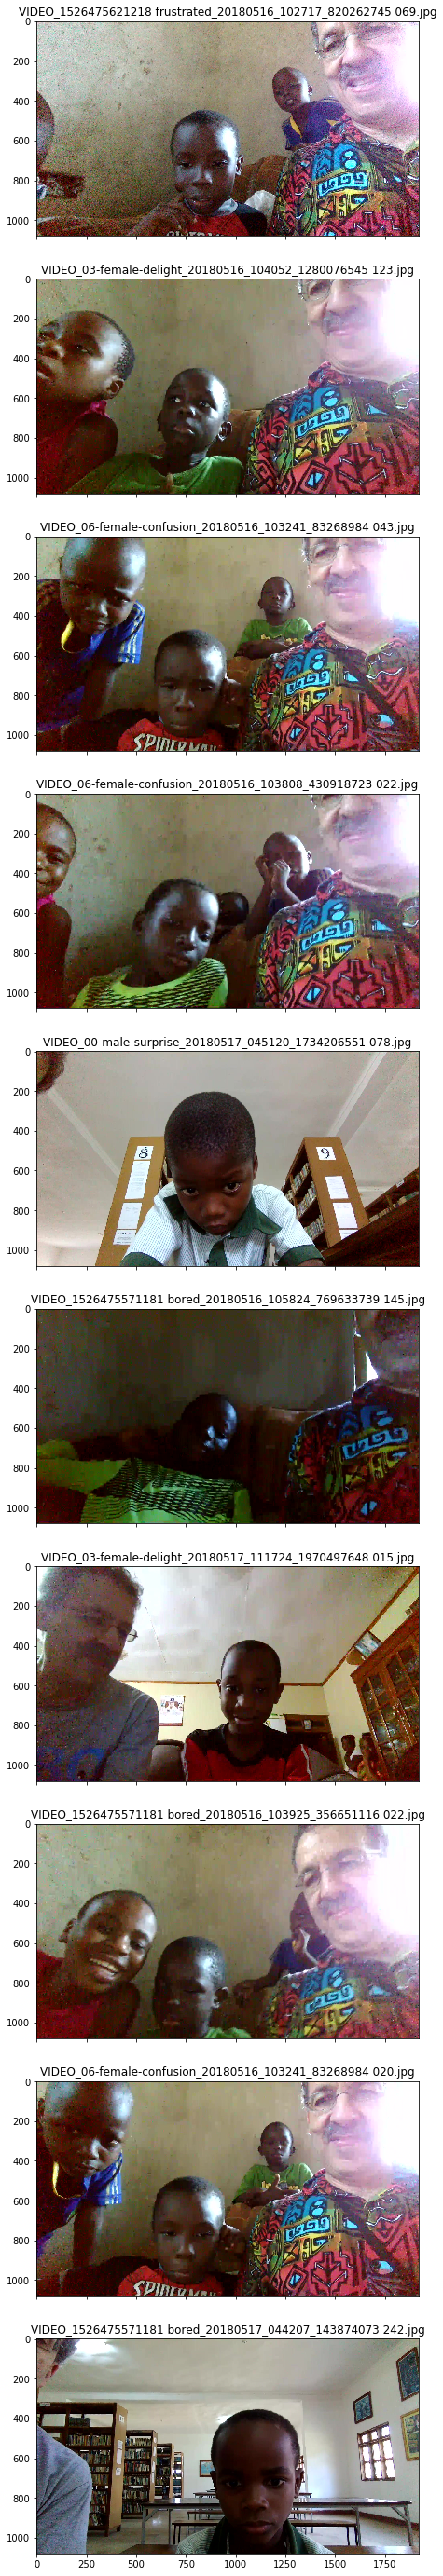

In [23]:
getRandomImages('output_XML/zface-output.xml', images_folder='/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/', has_box=False)

('Number of images: ', 27978)
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_10-male-confusion_20180517_111505_514046865 (5-29-2018 10-29-50 AM)/VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_110007_2013844995 (5-24-2018 7-28-24 PM)/VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_10-male-confusion_20180517_044319_1843081390 (5-27-2018 5-44-52 AM)/VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_1526469405985 make a face like this one_20180517_111651_1279829377 (5-27-2018 6-42-06 AM)/VIDEO_1526469405985 make a face like this one_20180517_111651_1279829377 27.jpg')
('image path

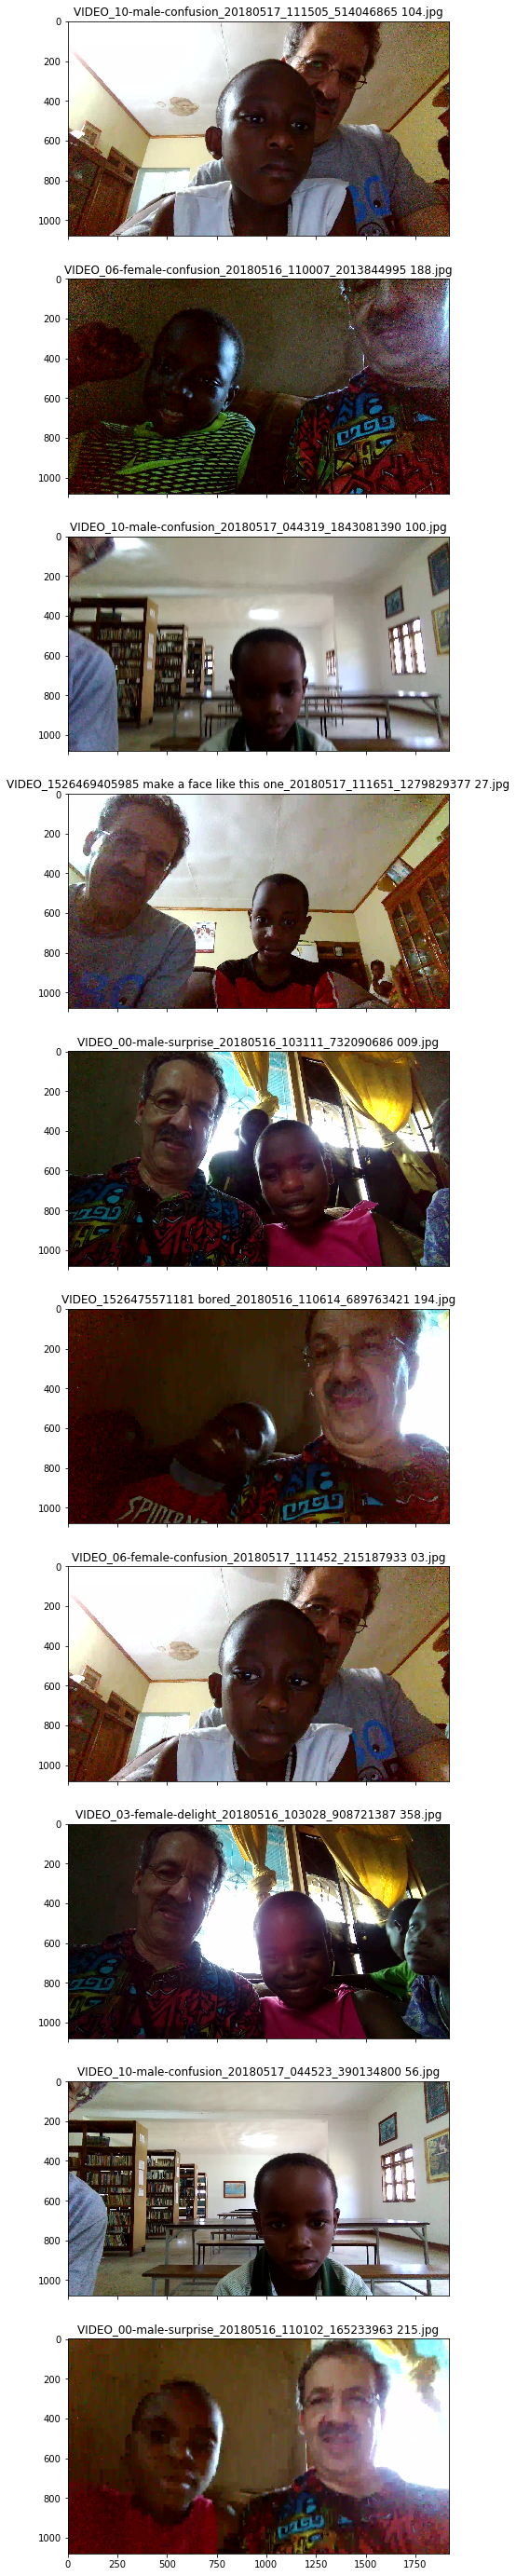

In [27]:
listRandomImages = getRandomImages('output_XML/zface-output.xml', images_folder='/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/', has_box=False)

('Number of images: ', 27978)


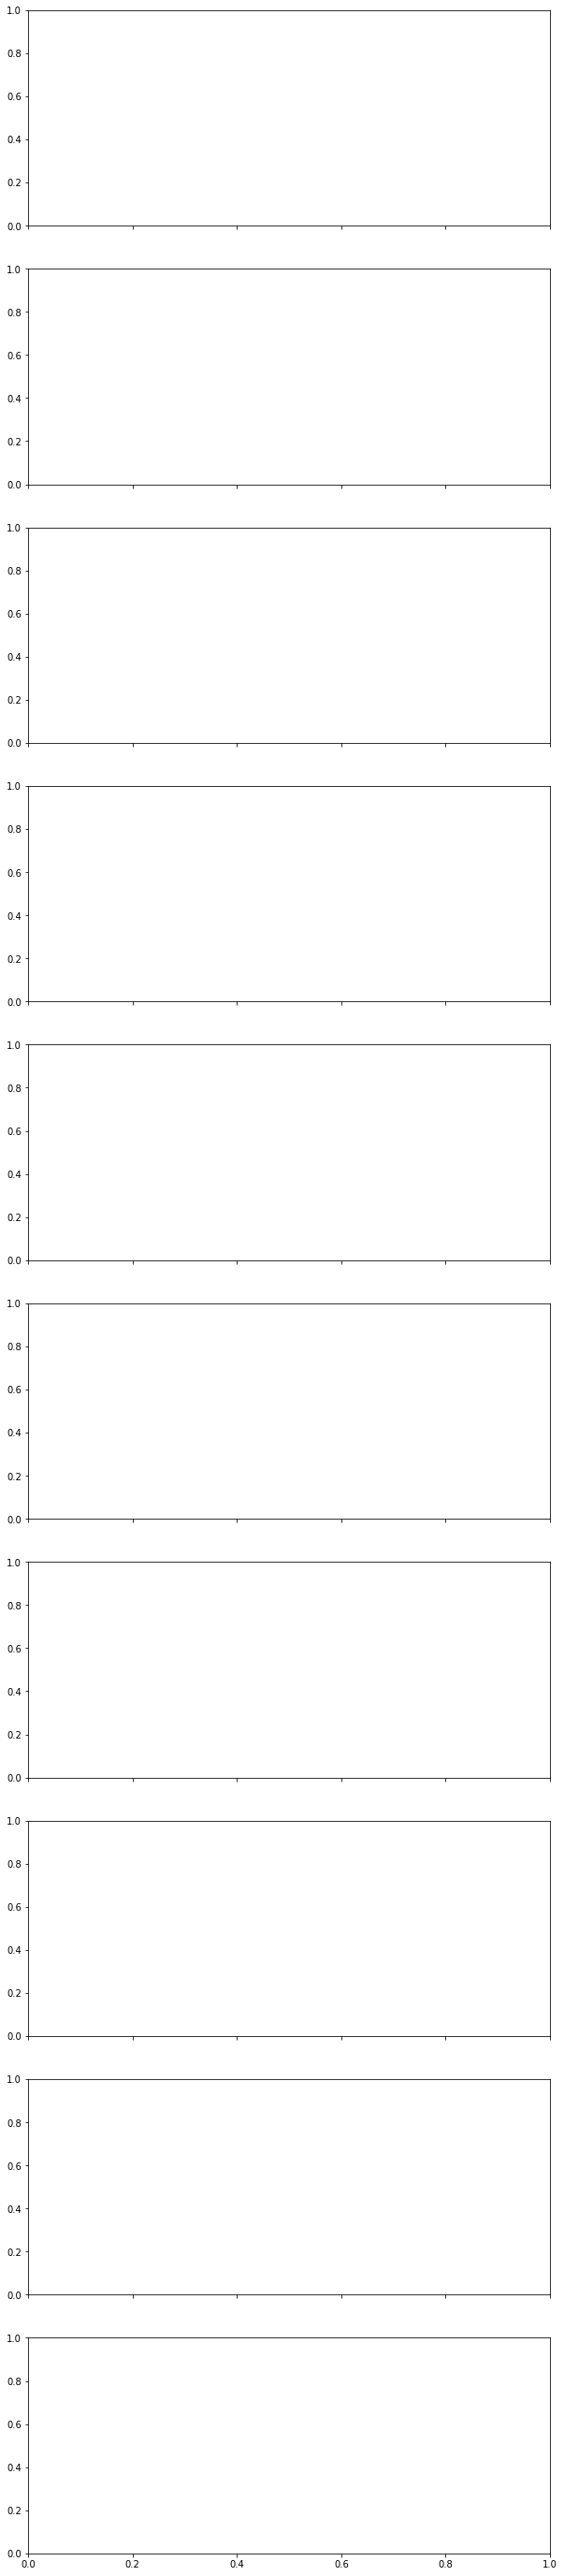

In [23]:
listRandomImages = getRandomImages('output_XML/zface-output.xml', images_folder='/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/', has_box=False)

On the 10 images above, do the following:
- Manually crop out small parts and run all three detectors.
- Monocolor the parts outside the manually labelled box(in 3 ways) and then try.
- Basically save the images in a folder and then see the results later.

    

### 1

In [425]:
str((round(time.time() * 1000)))[11:]

'4e+12'

In [426]:
def processImage(path,x,y,w,h,save_images=False):
    image = cv2.imread(path)
    # see the bounding box
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
    avg_color = image.mean(axis=0).mean(axis=0)
#     print(image.mean(axis=0).mean(axis=0))
    im_avg = np.uint8(avg_color) * np.ones(image.shape, np.uint8)
    im_empty = np.zeros(image.shape, np.uint8)
#     im_empty = np.ones(image.shape, np.uint8)
    #get face patch
    im_face_only = image[y:y+h,x:x+w]
    #paste patch 
    im_empty[y:y+h,x:x+w] = im_face_only
    im_avg[y:y+h,x:x+w] = im_face_only
#     plt.imshow(cv2.cvtColor(im_empty,cv2.COLOR_BGR2RGB))
#     plt.imshow(cv2.cvtColor(im_avg,cv2.COLOR_BGR2RGB))
#     plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        
    #Plot images
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    ax0.imshow(cv2.cvtColor(im_avg,cv2.COLOR_BGR2RGB))
    ax0.set_title('Average color')
    ax0.axis('off')
    ax1.imshow(cv2.cvtColor(im_empty,cv2.COLOR_BGR2RGB))
    ax1.set_title('Empty')
    ax1.axis('off')
    plt.show(fig)
    
    # Save images
    if save_images:
        base_name = os.path.basename(path)
        ts = str((round(time.time() * 1000)))[11:]
        output_folder_path = 'output_images/'+ts+'_'
        crop_image_name = output_folder_path + 'crop_' + base_name
        print('crop image saved as: ', crop_image_name)
        cv2.imwrite(crop_image_name,im_face_only)
        empty_image_name = output_folder_path + 'empty_' + base_name
        print('empty image saved as: ', empty_image_name)
        cv2.imwrite(empty_image_name,im_empty)
        avg_image_name = output_folder_path + 'avg_' + base_name
        print('avg image saved as: ', avg_image_name)
        cv2.imwrite(avg_image_name,im_avg)
        return crop_image_name,empty_image_name,avg_image_name

In [478]:
path = listRandomImages[0]

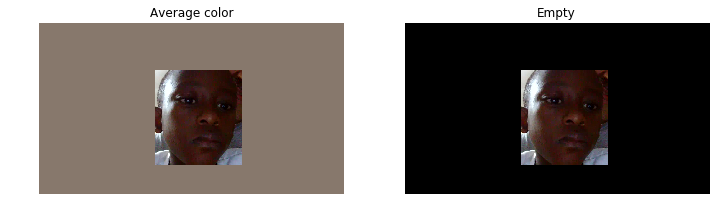

('crop image saved as: ', 'output_images/9e+12_crop_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('empty image saved as: ', 'output_images/9e+12_empty_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('avg image saved as: ', 'output_images/9e+12_avg_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')


('output_images/9e+12_crop_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg',
 'output_images/9e+12_empty_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg',
 'output_images/9e+12_avg_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')

In [479]:
processImage(path,730,300,550,600,save_images=True)

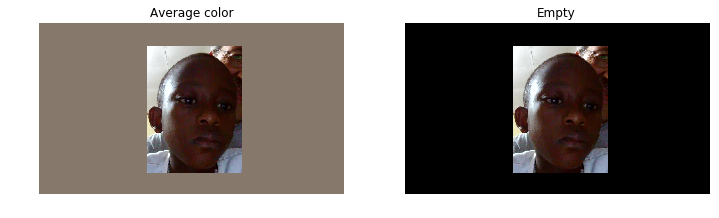

('crop image saved as: ', 'output_images/19e+12_crop_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('empty image saved as: ', 'output_images/19e+12_empty_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('avg image saved as: ', 'output_images/19e+12_avg_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')


('output_images/19e+12_crop_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg',
 'output_images/19e+12_empty_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg',
 'output_images/19e+12_avg_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')

In [480]:
processImage(path,680,150,600,800,save_images=True)

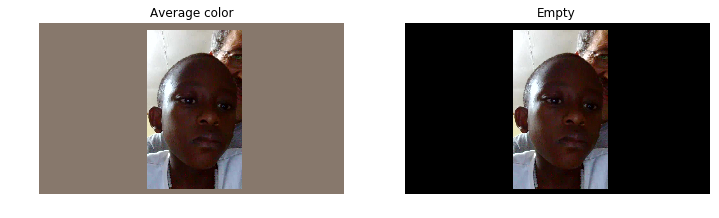

('crop image saved as: ', 'output_images/84e+12_crop_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('empty image saved as: ', 'output_images/84e+12_empty_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')
('avg image saved as: ', 'output_images/84e+12_avg_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')


('output_images/84e+12_crop_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg',
 'output_images/84e+12_empty_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg',
 'output_images/84e+12_avg_VIDEO_10-male-confusion_20180517_111505_514046865 104.jpg')

In [481]:
processImage(path,680,50,600,1000,save_images=True)

### 2

In [482]:
path = listRandomImages[1]

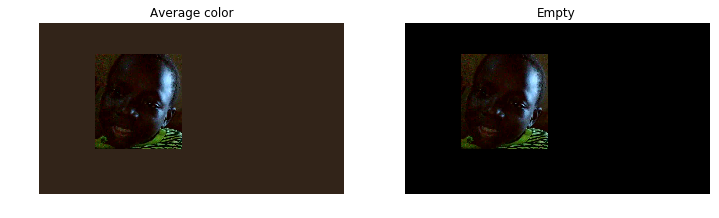

('crop image saved as: ', 'output_images/85e+12_crop_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('empty image saved as: ', 'output_images/85e+12_empty_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('avg image saved as: ', 'output_images/85e+12_avg_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')


('output_images/85e+12_crop_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg',
 'output_images/85e+12_empty_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg',
 'output_images/85e+12_avg_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')

In [483]:
processImage(path,350,200,550,600,save_images=True)

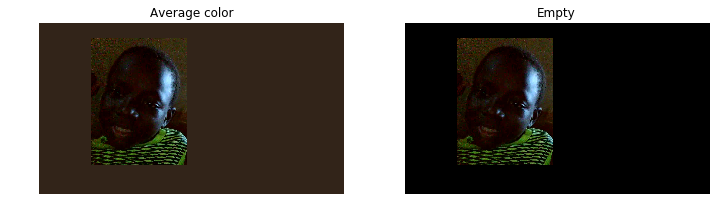

('crop image saved as: ', 'output_images/24e+12_crop_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('empty image saved as: ', 'output_images/24e+12_empty_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('avg image saved as: ', 'output_images/24e+12_avg_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')


('output_images/24e+12_crop_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg',
 'output_images/24e+12_empty_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg',
 'output_images/24e+12_avg_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')

In [484]:
processImage(path,330,100,600,800,save_images=True)

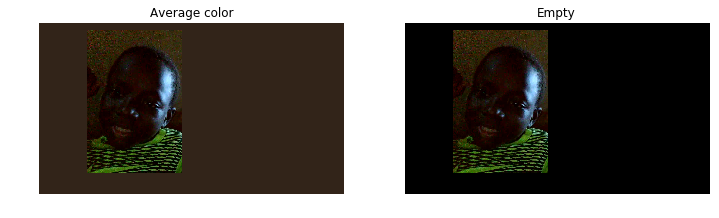

('crop image saved as: ', 'output_images/85e+12_crop_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('empty image saved as: ', 'output_images/85e+12_empty_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')
('avg image saved as: ', 'output_images/85e+12_avg_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')


('output_images/85e+12_crop_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg',
 'output_images/85e+12_empty_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg',
 'output_images/85e+12_avg_VIDEO_06-female-confusion_20180516_110007_2013844995 188.jpg')

In [485]:
processImage(path,300,50,600,900,save_images=True)

### 3

In [486]:
path = listRandomImages[2]

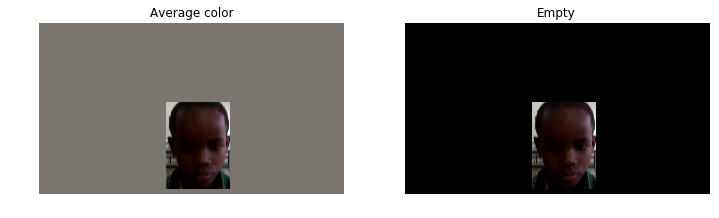

('crop image saved as: ', 'output_images/72e+12_crop_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('empty image saved as: ', 'output_images/72e+12_empty_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('avg image saved as: ', 'output_images/72e+12_avg_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')


('output_images/72e+12_crop_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg',
 'output_images/72e+12_empty_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg',
 'output_images/72e+12_avg_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')

In [487]:
processImage(path,800,500,400,550,save_images=True)

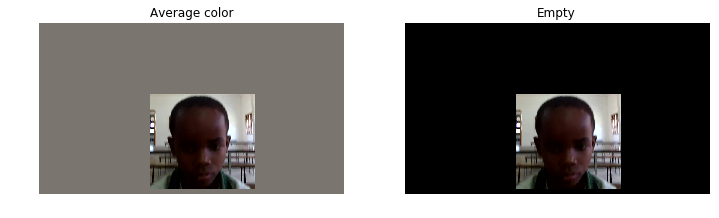

('crop image saved as: ', 'output_images/1e+12_crop_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('empty image saved as: ', 'output_images/1e+12_empty_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('avg image saved as: ', 'output_images/1e+12_avg_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')


('output_images/1e+12_crop_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg',
 'output_images/1e+12_empty_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg',
 'output_images/1e+12_avg_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')

In [488]:
processImage(path,700,450,660,600,save_images=True)

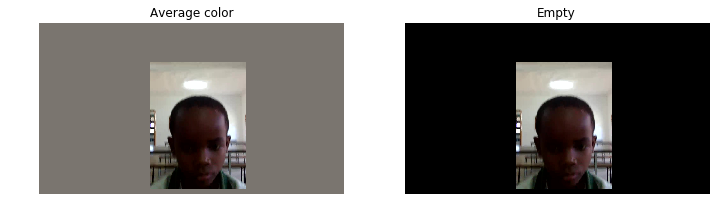

('crop image saved as: ', 'output_images/7e+12_crop_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('empty image saved as: ', 'output_images/7e+12_empty_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')
('avg image saved as: ', 'output_images/7e+12_avg_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')


('output_images/7e+12_crop_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg',
 'output_images/7e+12_empty_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg',
 'output_images/7e+12_avg_VIDEO_10-male-confusion_20180517_044319_1843081390 100.jpg')

In [489]:
processImage(path,700,250,600,800,save_images=True)

## Result for face detection on original, cropped, avg, empty

### dlib

In [304]:
args={"shape_predictor":"shape_predictor_68_face_landmarks.dat"}
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

##### original

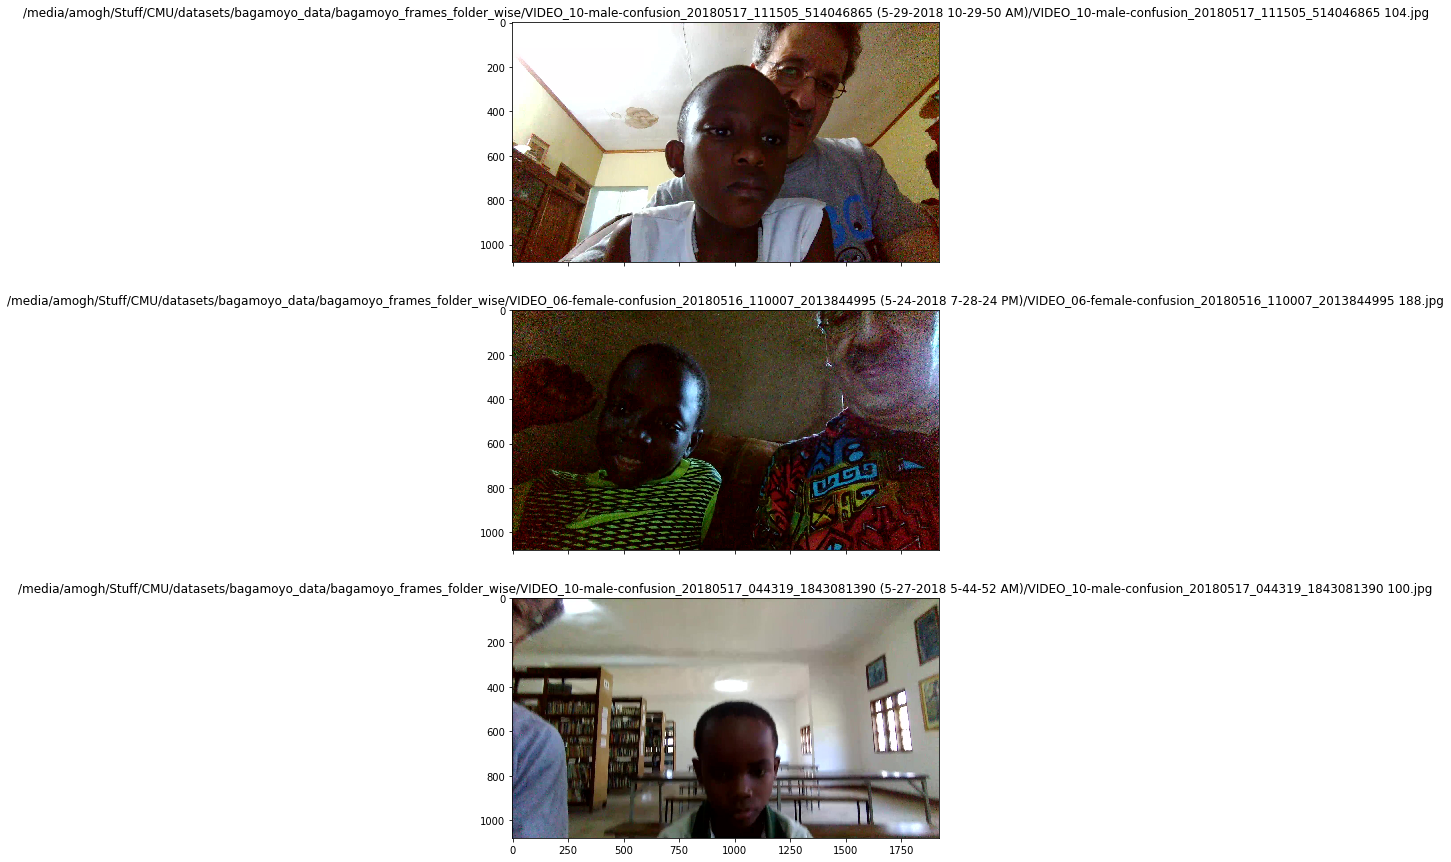

In [299]:
list_paths = listRandomImages
number_of_images = len(list_paths)
number_of_images = 3
fig,axes=plt.subplots(number_of_images,1,sharex=True,sharey=True,figsize=(20,5*number_of_images))
for im_no,im_name in enumerate(list_paths[:3]):
    image = cv2.imread(im_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
#         print(shape.shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
    axes[im_no].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    axes[im_no].set_title(im_name.split('_',1)[0])
    axes[im_no].set_title(im_name)

##### Processed

In [30]:
path_processed_images = 'output_images/'
list_path_processed_images = glob.glob(path_processed_images + '/*')
number_of_images = len(list_path_processed_images)
fig,axes=plt.subplots(number_of_images/3,3,sharex=True,sharey=True,figsize=(10,5*number_of_images))
for im_no,im_name in enumerate(list_path_processed_images):
    image = cv2.imread(im_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
#         print(shape.shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
    axes[im_no].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    axes[im_no].set_title(im_name.split('_',1)[0])
    axes[im_no].set_title(im_name)

SyntaxError: invalid syntax (<ipython-input-30-db9459ebdf57>, line 4)

**Result - ** <br>
Original - no detections with dlib <br>
Processed - successful detection for one of them


### ZFace

### OpenFace

### Histogram visualisation

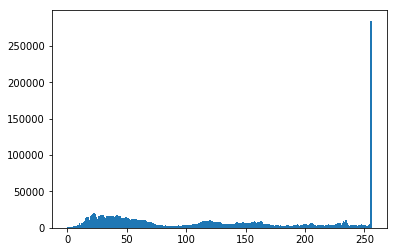

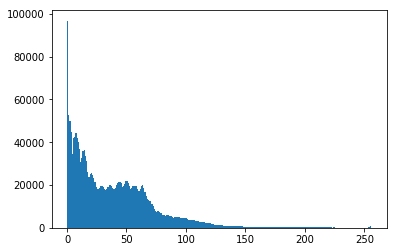

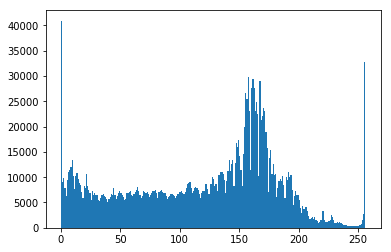

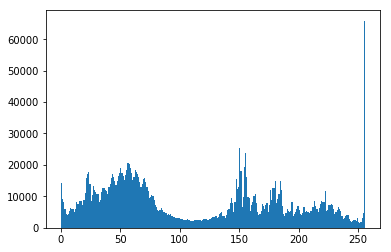

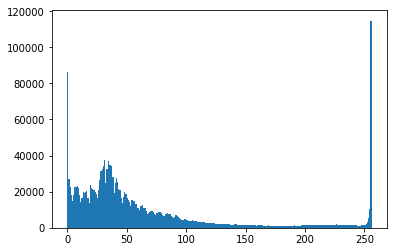

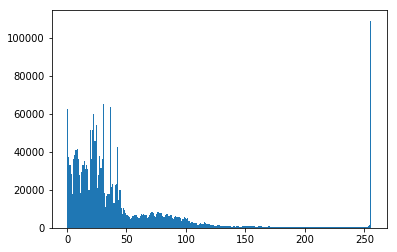

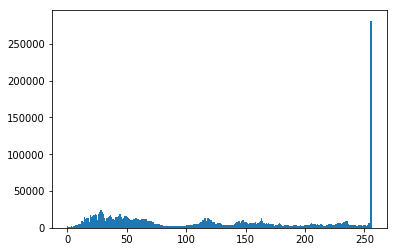

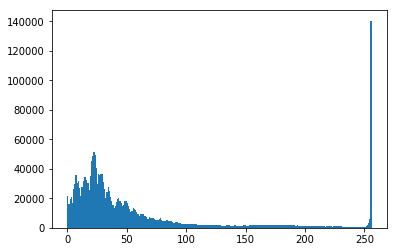

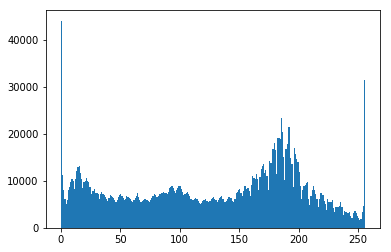

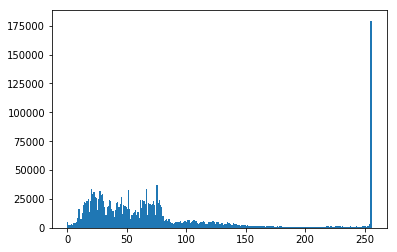

In [444]:
for path in listRandomImages:
    img = cv2.imread(path,0)
#     color = ('b','g','r')
    plt.hist(img.ravel(),256,[0,256]); plt.show()

#### Histogram Normalisation

In [1]:
number_of_images = len(listRandomImages)
fig,axes=plt.subplots(number_of_images,1,sharex=True,sharey=True,figsize=(10,5*number_of_images))
for path in listRandomImages[:2]:
    img = cv2.imread(path,0)
    equ = cv2.equalizeHist(img)
    res = np.hstack((img,equ)) #stacking images side-by-side
#     plt.imshow(res,cmap='gray')
    axes[im_no].imshow(res,cmap='gray')

NameError: name 'listRandomImages' is not defined

24


NameError: name 'detector' is not defined

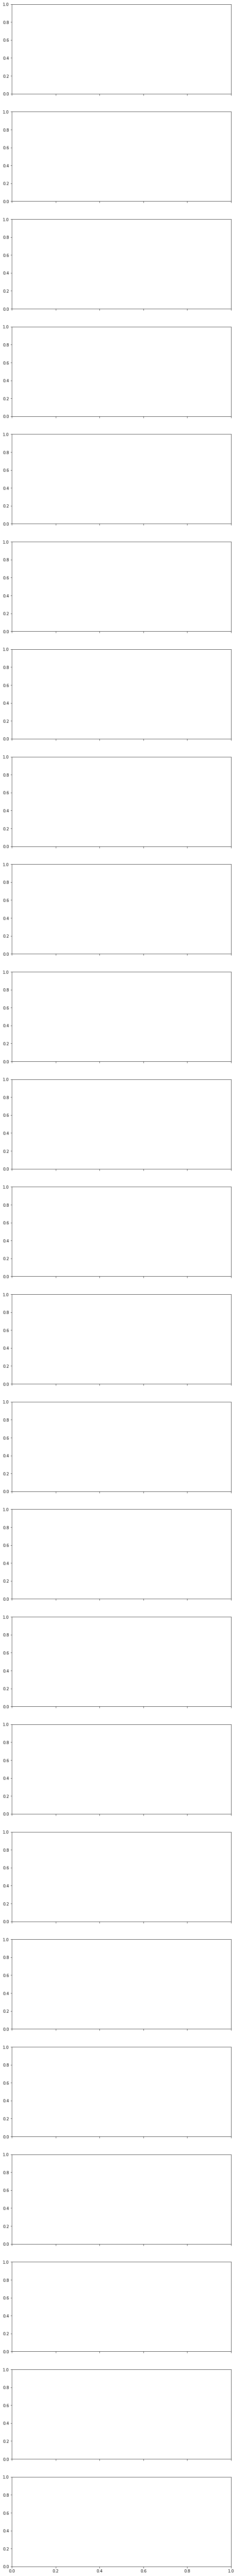

In [29]:
path_processed_images = 'output_images/'
list_path_processed_images = glob.glob(path_processed_images + '/*')
number_of_images = len(list_path_processed_images)
print(number_of_images)
fig,axes=plt.subplots(number_of_images,1,sharex=True,sharey=True,figsize=(10,5*number_of_images))
for im_no,im_name in enumerate(list_path_processed_images):
    image = cv2.imread(im_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    rects = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array    
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
#         print(shape.shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
    axes[im_no].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    axes[im_no].set_title(im_name.split('_',1)[0])
    axes[im_no].set_title(im_name)
plt.show()

TODO Experiments
- Face detection (2 hrs), try to visualise and understand exactly why HOG isn't working here, try to see the values obtained when similarity across each window is calculated.
    - Try to detect face in cropped images.
    - Try to detect face when background is of same color(try average, white, black).
- See the values in terms of HOG detector, what is going wrong. Read about it and see which visualisations are wrong.